# Reversible-Jump MCMC with Eryn

This notebook demonstrates how to use the `DiscoveryErynRJBridge` for reversible-jump MCMC
sampling on Discovery models with variable numbers of signal components.

**Use case**: When you don't know how many signals are in your data (e.g., gravitational wave
sources in PTA data), RJMCMC allows the sampler to jump between models with different numbers
of components.

## Key Components

1. **`RJ_Discovery_model`**: Wrapper class that caches likelihoods for all model configurations
   (e.g., 1 source, 2 sources, etc.)
   
2. **`DiscoveryErynRJBridge`**: Interface to Eryn's RJMCMC sampler with proper prior handling

## Prior Format

For RJMCMC, priors are specified by **branch** (component type) and **parameter index**:

```python
priors = {
    "branch_name": {
        0: uniform_dist(min0, max0),  # Prior for parameter 0
        1: uniform_dist(min1, max1),  # Prior for parameter 1
        ...
    }
}
```

This differs from the standard MCMC interface where priors are keyed by parameter name.

## Setup

In [12]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)

# Import Eryn components
from eryn.prior import uniform_dist

# Import Discovery and discoverysamplers
import discovery as ds
from discoverysamplers.eryn_RJ_interface import RJ_Discovery_model, DiscoveryErynRJBridge

## Example: Toy Model with Variable Number of Gaussians

For this demonstration, we'll create a simple toy model that doesn't require PTA data.
The model has a variable number of Gaussian signals, each with 2 parameters (mean and amplitude).

**Note**: For real PTA analysis, you would use Discovery's pulsar likelihoods as shown
in the later sections.

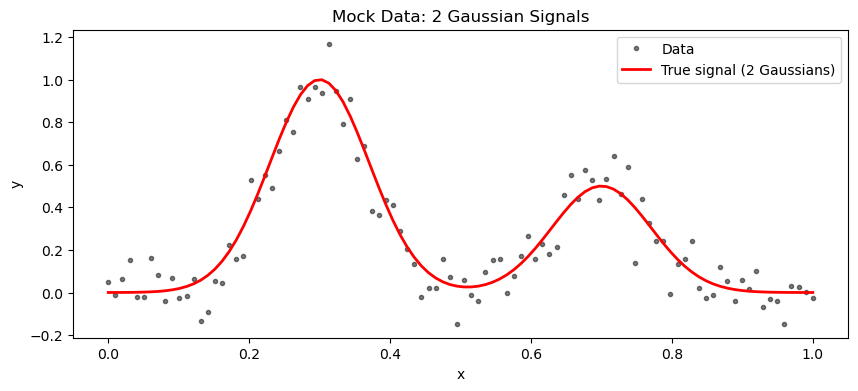

In [13]:
# Simple demonstration using Eryn's RJ sampler directly
# (without Discovery, just to show the interface)

# Number of Gaussian components can vary from 1 to 3
nleaves_min = 1
nleaves_max = 3

# True values for 2 Gaussians in our mock data
true_means = [0.3, 0.7]
true_amps = [1.0, 0.5]

# Generate mock data
np.random.seed(42)
x_data = np.linspace(0, 1, 100)
y_true = sum(a * np.exp(-100 * (x_data - m)**2) for m, a in zip(true_means, true_amps))
y_data = y_true + 0.1 * np.random.randn(len(x_data))

# Plot the data
plt.figure(figsize=(10, 4))
plt.plot(x_data, y_data, 'k.', alpha=0.5, label='Data')
plt.plot(x_data, y_true, 'r-', lw=2, label='True signal (2 Gaussians)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Mock Data: 2 Gaussian Signals')
plt.show()

In [14]:
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.moves import GaussianMove

# Define log-likelihood for variable number of Gaussians
# Eryn passes *params as nested lists
def logL_gaussians(*params):
    """Log-likelihood for variable number of Gaussian components.
    
    params is a tuple of arrays, one per branch. For our single branch 'gauss',
    params[0] has shape (n_active_sources, n_params_per_source) = (n, 2)
    where n varies with the model.
    """
    gauss_params = params[0]  # Shape: (n_sources, 2) where 2 = [mean, amplitude]
    
    # Build model prediction
    y_model = np.zeros_like(x_data)
    for source_params in gauss_params:
        mean, amp = source_params
        y_model += amp * np.exp(-100 * (x_data - mean)**2)
    
    # Gaussian log-likelihood
    sigma = 0.1
    chi2 = np.sum((y_data - y_model)**2) / sigma**2
    logL = -0.5 * chi2 - 0.5 * len(x_data) * np.log(2 * np.pi * sigma**2)
    
    return logL

# Test the likelihood with 2 sources
test_params = [np.array([[0.3, 1.0], [0.7, 0.5]])]
print(f"Log-likelihood with true params: {logL_gaussians(*test_params):.2f}")

Log-likelihood with true params: 97.00


In [15]:
# Set up the RJMCMC sampler
ndim = 2  # Parameters per source: [mean, amplitude]
nwalkers = 32
ntemps = 2

branch_names = ["gauss"]

# Priors: indexed by parameter position (0 = mean, 1 = amplitude)
priors = {
    "gauss": {
        0: uniform_dist(0, 1),   # mean in [0, 1]
        1: uniform_dist(0, 2),   # amplitude in [0, 2]
    }
}

# Moves for in-model steps
cov = {"gauss": np.diag([0.01, 0.01])}  # Diagonal covariance
moves = GaussianMove(cov)

# Create the sampler
sampler = EnsembleSampler(
    nwalkers,
    ndim,
    logL_gaussians,
    priors=priors,
    tempering_kwargs={"ntemps": ntemps},
    nbranches=1,
    branch_names=branch_names,
    nleaves_max=nleaves_max,
    nleaves_min=nleaves_min,
    moves=moves,
    rj_moves=True,  # Enable reversible-jump
)

print("Sampler created successfully!")
print(f"  Branch: {branch_names}")
print(f"  Min sources: {nleaves_min}")
print(f"  Max sources: {nleaves_max}")
print(f"  Params per source: {ndim}")

Sampler created successfully!
  Branch: ['gauss']
  Min sources: 1
  Max sources: 3
  Params per source: 2


In [16]:
# Initialize state with 2 sources (the true model)
initial_nleaves = 2

# Coordinates: shape (ntemps, nwalkers, nleaves_max, ndim)
coords = {"gauss": np.zeros((ntemps, nwalkers, nleaves_max, ndim))}

# Active leaves indicator
inds = {"gauss": np.zeros((ntemps, nwalkers, nleaves_max), dtype=bool)}
inds["gauss"][:, :, :initial_nleaves] = True  # Start with 2 active

# Initialize coordinates near true values with scatter
for leaf_idx in range(initial_nleaves):
    # Mean
    coords["gauss"][:, :, leaf_idx, 0] = np.random.normal(
        loc=true_means[leaf_idx], scale=0.05, size=(ntemps, nwalkers)
    )
    # Amplitude
    coords["gauss"][:, :, leaf_idx, 1] = np.random.normal(
        loc=true_amps[leaf_idx], scale=0.1, size=(ntemps, nwalkers)
    )

# Compute initial log-prior and log-likelihood
log_prior = sampler.compute_log_prior(coords, inds=inds)
log_like = sampler.compute_log_like(coords, inds=inds, logp=log_prior)[0]

print(f"Initial log-likelihood (max): {log_like.max():.2f}")
print(f"Initial log-prior (max): {log_prior.max():.2f}")

# Create state
state = State(coords, log_like=log_like, log_prior=log_prior, inds=inds)

Initial log-likelihood (max): 89.66
Initial log-prior (max): -1.39


In [17]:
# Run the sampler
nsteps = 2000

print(f"Running RJMCMC for {nsteps} steps...")
final_state = sampler.run_mcmc(state, nsteps, progress=True, thin_by=1)

Running RJMCMC for 2000 steps...


100%|██████████| 2000/2000 [00:04<00:00, 447.16it/s]


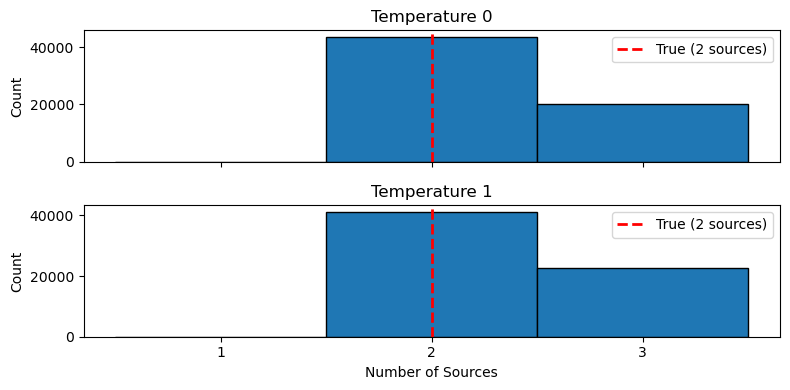


Model selection (cold chain):
  1 sources: 0.0%
  2 sources: 68.3%
  3 sources: 31.7%


In [18]:
# Plot the posterior on number of sources
nleaves = sampler.get_nleaves()["gauss"]
# Shape: (nsteps, ntemps, nwalkers)

bins = np.arange(nleaves_min - 0.5, nleaves_max + 1.5)

fig, axes = plt.subplots(ntemps, 1, sharex=True, figsize=(8, 4))
if ntemps == 1:
    axes = [axes]

for temp, ax in enumerate(axes):
    ax.hist(nleaves[:, temp].flatten(), bins=bins, edgecolor='black')
    ax.axvline(2, color='r', linestyle='--', lw=2, label='True (2 sources)')
    ax.set_ylabel('Count')
    ax.set_title(f'Temperature {temp}')
    ax.legend()

axes[-1].set_xlabel('Number of Sources')
axes[-1].set_xticks(range(nleaves_min, nleaves_max + 1))
plt.tight_layout()
plt.show()

# Print model selection summary
cold_nleaves = nleaves[:, 0].flatten()
print("\nModel selection (cold chain):")
for n in range(nleaves_min, nleaves_max + 1):
    frac = (cold_nleaves == n).mean() * 100
    print(f"  {n} sources: {frac:.1f}%")

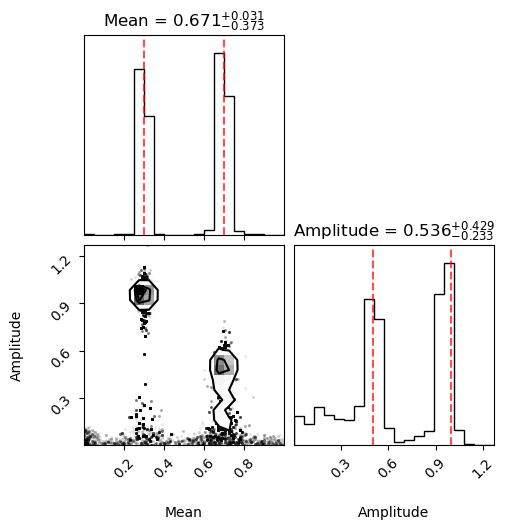

In [19]:
# Corner plot for parameter posteriors
import corner

# Get samples from cold chain
samples = sampler.get_chain()["gauss"][:, 0]  # (nsteps, nwalkers, nleaves_max, ndim)
flat_samples = samples.reshape(-1, ndim)

# Remove NaN entries (inactive leaves)
valid_mask = ~np.isnan(flat_samples[:, 0])
flat_samples = flat_samples[valid_mask]

# Corner plot
fig = corner.corner(
    flat_samples,
    labels=["Mean", "Amplitude"],
    truths=None,  # Can't show single truth with multiple sources
    show_titles=True,
    title_fmt=".3f",
)

# Add true values as vertical lines
ax_mean = fig.axes[0]
for m in true_means:
    ax_mean.axvline(m, color='r', linestyle='--', alpha=0.7)

ax_amp = fig.axes[3]
for a in true_amps:
    ax_amp.axvline(a, color='r', linestyle='--', alpha=0.7)

plt.show()

---

## Using `RJ_Discovery_model` with PTA Data

For real PTA analysis with Discovery, use the `RJ_Discovery_model` class to manage
multiple model configurations. Below is the template structure.

**Note**: This requires pulsar data files which may not be available in all environments.

In [ ]:
# Load pulsar data
import os
import glob

# Path to pulsar data (adjust for your setup)
FEATHER_PATH = "../data/20nHz_-13.5_wn_ds_noTM_feathers"

# Check if data exists
feather_files = sorted(glob.glob(os.path.join(FEATHER_PATH, '*')))
if not feather_files:
    raise FileNotFoundError(f"No pulsar data found at {FEATHER_PATH}. Adjust the path!")

print(f"Found {len(feather_files)} pulsar files")

# Load pulsars
allpsrs = [ds.Pulsar.read_feather(f) for f in feather_files]
print(f"Loaded {len(allpsrs)} pulsars: {[p.name for p in allpsrs]}")

### Step 1: Define the Signal Model

For RJMCMC, we need a **signal constructor** function that:
1. Returns a tuple `(delay_function, parameter_names)` when called
2. The `delay_function` computes the timing residual induced by a gravitational wave source
3. The `parameter_names` list contains the names of the sampled parameters (excluding pulsar attributes like `toas` and `pos`)

Here we define a continuous gravitational wave (CW) signal from a supermassive black hole binary:

In [ ]:
from discovery.deterministic import fpc_fast
from discovery import const

def makedelay_binary_evolution_nopsrterm(evolve=False):
    """
    Create a CW delay function for binary evolution without pulsar term.
    
    Returns
    -------
    delay_binary : function
        The delay function that computes timing residuals
    names : list
        Parameter names (excluding toas and pos which are pulsar attributes)
    """
    def delay_binary(toas, pos, log10_h0, log10_f0, ra, sindec, cosinc, psi, phi_earth, log10_Mc):
        h0 = 10**log10_h0
        f0 = 10**log10_f0
        dec, inc = jnp.arcsin(sindec), jnp.arccos(cosinc)
        fplus, fcross = fpc_fast(pos, 0.5 * jnp.pi - dec, ra)
        phi_avg = phi_earth
        tref = 0.
        
        if evolve:
            Mc = 10**log10_Mc * const.Tsun
            f = f0 * (1 - 256/5 * Mc**(5/3) * ((jnp.pi*f0)**(8/3) * (toas - tref)))**(-3/8)
            phase = phi_avg + 2 * (1/32) * (1/Mc**(5/3)) * ((jnp.pi * f0)**(-5/3) - (jnp.pi * f)**(-5/3))
        else:
            phase = phi_avg + 2.0 * jnp.pi * f0 * (toas - tref)
        
        cphase, sphase = jnp.cos(phase), jnp.sin(phase)
        delta_sin, delta_cos = sphase, cphase
        At = -1.0 * (1.0 + jnp.cos(inc)**2) * delta_sin
        Bt = 2.0 * jnp.cos(inc) * delta_cos
        alpha = h0 / (2 * jnp.pi * f0)
        rplus = alpha * (-At * jnp.cos(2 * psi) + Bt * jnp.sin(2 * psi))
        rcross = alpha * (At * jnp.sin(2 * psi) + Bt * jnp.cos(2 * psi))
        return -fplus * rplus - fcross * rcross
    
    # Parameter names (excluding toas and pos which are pulsar attributes)
    names = ["log10_h0", "log10_f0", "ra", "sindec", "cosinc", "psi", "phi_earth", "log10_Mc"]
    return delay_binary, names

# Test that it returns the expected structure
delay_fn, param_names = makedelay_binary_evolution_nopsrterm()
print(f"Signal constructor returns: (function, {param_names})")

### Step 2: Define Fixed Components

Fixed components are parts of the model that **don't change** between RJMCMC configurations. These typically include:
- The pulsar residuals (data)
- The noise model (EFAC, EQUAD, etc.)
- Timing model marginalization
- Optional: DM variations, red noise

These are defined as a function that takes a pulsar and returns a list of model components:

In [ ]:
def make_fixed_components_per_psr(psr):
    """
    Create fixed components for a pulsar - components that don't vary in number.
    
    These include:
    - Residuals (the data)
    - White noise model (EFAC, EQUAD)
    - Timing model marginalization
    - Optional: DM GP and red noise (if specified in noisedict)
    """
    components = [
        psr.residuals,
        ds.makenoise_measurement(psr, psr.noisedict, tnequad=True),
        ds.makegp_timing(psr, svd=True),
    ]
    
    # Optional DM GP components (chromatic noise)
    if psr.noisedict.get(psr.name + '_dm_gp_components', 0):
        components.append(
            ds.makegp_fourier(
                psr, ds.powerlaw,
                psr.noisedict[psr.name + '_dm_gp_components'],
                T=ds.getspan(psr),
                name='dm_gp',
                fourierbasis=ds.make_dmfourierbasis(alpha=2.0, tndm=True),
            )
        )
    
    # Optional red noise components (achromatic noise)
    if psr.noisedict.get(psr.name + '_red_components', 0):
        components.append(
            ds.makegp_fourier(
                psr, ds.powerlaw,
                psr.noisedict[psr.name + '_red_components'],
                T=ds.getspan([psr]),
                name='red_noise',
            )
        )
    return components

# Test on first pulsar
test_components = make_fixed_components_per_psr(allpsrs[0])
print(f"Fixed components for {allpsrs[0].name}: {len(test_components)} components")

### Step 3: Create the RJ Model

Now we combine everything into an `RJ_Discovery_model`. This class:
1. Pre-computes and caches Discovery likelihoods for **all possible configurations**
2. Provides a unified `logL(*params)` interface that Eryn can call

The key inputs are:
- `fixed_components`: Components that stay the same (noise model)
- `variable_components`: Components that can vary in number (CW sources)
- `variable_component_numbers`: Min and max count for each variable component

In [ ]:
# Base parameter names for CW signal (must match what constructor returns)
base_names = ["log10_h0", "log10_f0", "ra", "sindec", "cosinc", "psi", "phi_earth", "log10_Mc"]

# Fixed components: noise model per pulsar
fixed_components = {
    'per_psr': {'base': make_fixed_components_per_psr}
}

# Variable components: CW sources (global = same source seen by all pulsars)
variable_components = {
    'global': {'cw': (makedelay_binary_evolution_nopsrterm, base_names)}
}

# How many sources can we have?
variable_component_numbers = {
    'cw': (1, 3),  # Allow 1 to 3 CW sources
}

print("Creating RJ model...")
print("This pre-computes likelihoods for all configurations (may take a moment)...")

rj_model = RJ_Discovery_model(
    psrs=allpsrs,
    fixed_components=fixed_components,
    variable_components=variable_components,
    variable_component_numbers=variable_component_numbers,
    verbose=True,
)

In [ ]:
# Inspect the available configurations
print("Available model configurations:")
for config in rj_model.get_all_configurations():
    lkl = rj_model.get_likelihood_for_config(config)
    n_params = len(lkl.logL.params)
    print(f"  {config}: {n_params} total parameters")

print(f"\nFixed parameters: {len(rj_model.fixed_params)}")
print(f"Variable parameters per source: {len(base_names)}")

### Step 4: Define Priors

For RJMCMC with Eryn, priors are specified in a different format than standard MCMC:
- **Standard MCMC**: `{'param_name': uniform_dist(min, max)}`
- **RJMCMC**: `{'branch_name': {param_index: uniform_dist(min, max)}}`

The parameter indices correspond to the order in `base_names`:

In [ ]:
# Show the parameter order
print("Parameter indices for priors:")
for i, name in enumerate(base_names):
    print(f"  {i}: {name}")

# Define priors (Eryn format: branch -> index -> distribution)
priors_rj = {
    "cw": {
        0: uniform_dist(-20, -11),    # log10_h0
        1: uniform_dist(-9, -7),       # log10_f0  
        2: uniform_dist(0, 2*np.pi),   # ra
        3: uniform_dist(-1, 1),        # sindec
        4: uniform_dist(-1, 1),        # cosinc
        5: uniform_dist(0, np.pi),     # psi
        6: uniform_dist(0, 2*np.pi),   # phi_earth
        7: uniform_dist(7, 10),        # log10_Mc
    }
}

print("\nPriors defined for branch 'cw'")

### Step 5: Create the Bridge and Sampler

The `DiscoveryErynRJBridge` wraps the RJ model and provides a high-level interface for sampling:

In [ ]:
# Create the bridge
bridge = DiscoveryErynRJBridge(rj_model, priors=priors_rj)

# Print summary
bridge.print_config_summary()

In [ ]:
# Create the sampler with parallel tempering
bridge.create_sampler(nwalkers=32, ntemps=2)

print(f"Sampler created with:")
print(f"  {bridge.nwalkers} walkers")
print(f"  {bridge.ntemps} temperatures")
print(f"  Min sources: {bridge.nleaves_min}")
print(f"  Max sources: {bridge.nleaves_max}")

### Step 6: Run the Sampler

Now we run the RJMCMC sampler. The sampler will:
- Start with `initial_nleaves` active sources
- Propose in-model moves (change parameters)
- Propose trans-dimensional moves (add/remove sources)

For production runs, use `nsteps=5000` or more. Here we use a short run for demonstration:

In [ ]:
# Run the sampler (short test run)
# For production, use nsteps=5000 or more
bridge.run_sampler(nsteps=100, initial_nleaves=1, progress=True)

### Step 7: Analyze Results

The key output from RJMCMC is the **posterior on the number of sources**. This tells us how many CW signals the data supports:

In [ ]:
# Plot the posterior on number of sources
fig = bridge.plot_nleaves_histogram()
plt.show()

# Print model selection results
print("\nModel selection results (cold chain):")
nleaves = bridge.return_nleaves()
cold_nleaves = nleaves[:, 0].flatten()
for n in range(bridge.nleaves_min, bridge.nleaves_max + 1):
    frac = (cold_nleaves == n).mean() * 100
    print(f"  {n} source(s): {frac:.1f}%")

In [ ]:
# Corner plot for parameter posteriors (optional)
# Note: This combines samples from all active sources
try:
    fig = bridge.plot_corner()
    plt.show()
except Exception as e:
    print(f"Corner plot skipped: {e}")